# Predicting tags from images

In this notebook, I use product features extracted by feeding products images into a pre-trained VGG16 CNN from Keras Applications to train 5 different models to try to predict every label in the articles.csv file.
<br>

All results and trained models are saved in pickle files as dictionaries with keys lableing the target variable and the trained model.
<br>

Five different models are defined but here I use Random Forest. You can edit 
'model, model name = ...' to select the model

# Output Sample
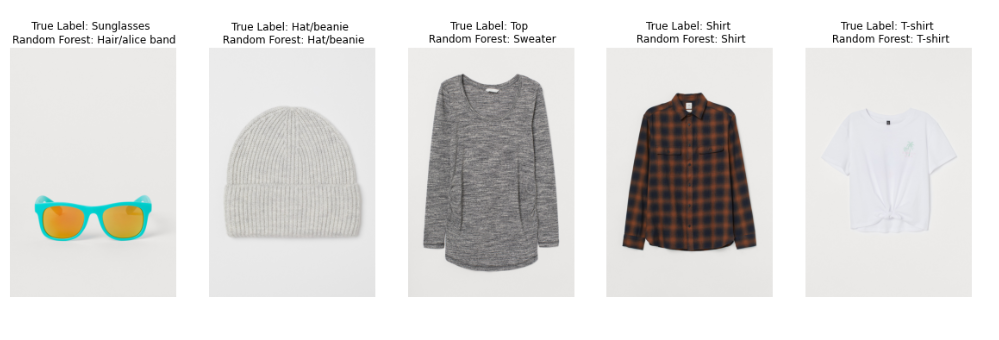

# Imports

In [1]:
import numpy as np
import pandas as pd
import pickle
import warnings

import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.linear_model import LogisticRegression as LR
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.svm import SVC

from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.model_selection import train_test_split
from sklearn.metrics import *

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['axes.grid'] = False
warnings.filterwarnings('ignore')

# Loading Data

In [2]:
f = open('../input/hm-articlecustomer-embeddings-from-images/article_embeddings_from_image.pickle', 'rb')
embeds = pickle.load(f)
embeds = pd.DataFrame(embeds).reset_index()
embeds.columns = ['article_id', 'embeds']
embeds.embeds = embeds.embeds.map(np.array)

In [3]:
embeds.head()

article_id                                             embeds
0  0108775015  [3.291787e-07, 1.2355815e-07, 2.049226e-05, 2....
1  0108775044  [5.4576713e-06, 3.4250597e-06, 4.4838875e-05, ...
2  0108775051  [1.43880325e-05, 2.0696747e-05, 5.7651476e-05,...
3  0110065001  [5.4223683e-12, 1.2656559e-11, 3.8108565e-09, ...
4  0110065002  [1.0652034e-06, 2.2579894e-05, 0.00044278972, ...

In [4]:
df = pd.read_csv('../input/h-and-m-personalized-fashion-recommendations/articles.csv', dtype={'article_id':str})
df = df.select_dtypes(object)
df = df.drop(['index_code', 'detail_desc', 'prod_name'], axis=1)

In [5]:
df.nunique()

article_id                      105542
product_type_name                  131
product_group_name                  19
graphical_appearance_name           30
colour_group_name                   50
perceived_colour_value_name          8
perceived_colour_master_name        20
department_name                    250
index_name                          10
index_group_name                     5
section_name                        56
garment_group_name                  21
dtype: int64

In [6]:
df = df.merge(embeds, on='article_id')

In [7]:
df.head()

article_id product_type_name  product_group_name graphical_appearance_name  \
0  0108775015          Vest top  Garment Upper body                     Solid   
1  0108775044          Vest top  Garment Upper body                     Solid   
2  0108775051          Vest top  Garment Upper body                    Stripe   
3  0110065001               Bra           Underwear                     Solid   
4  0110065002               Bra           Underwear                     Solid   

  colour_group_name perceived_colour_value_name perceived_colour_master_name  \
0             Black                        Dark                        Black   
1             White                       Light                        White   
2         Off White                 Dusty Light                        White   
3             Black                        Dark                        Black   
4             White                       Light                        White   

  department_name        index_name index_group_name            section_name  \
0    Jersey Basic        Ladieswear       Ladieswear  Womens Everyday Basics   
1    Jersey Basic        Ladieswear       Ladieswear  Womens Everyday Basics   
2    Jersey Basic        Ladieswear       Ladieswear  Womens Everyday Basics   
3  Clean Lingerie  Lingeries/Tights       Ladieswear         Womens Lingerie   
4  Clean Lingerie  Lingeries/Tights       Ladieswear         Womens Lingerie   

  garment_group_name                                             embeds  
0       Jersey Basic  [3.291787e-07, 1.2355815e-07, 2.049226e-05, 2....  
1       Jersey Basic  [5.4576713e-06, 3.4250597e-06, 4.4838875e-05, ...  
2       Jersey Basic  [1.43880325e-05, 2.0696747e-05, 5.7651476e-05,...  
3  Under-, Nightwear  [5.4223683e-12, 1.2656559e-11, 3.8108565e-09, ...  
4  Under-, Nightwear  [1.0652034e-06, 2.2579894e-05, 0.00044278972, ...

# Model Building

In [8]:
def twoLayerFeedForward():
    clf = Sequential()
    clf.add(Dense(1024, activation='relu', input_dim=1000))
    clf.add(Dense(2048, activation='relu'))
    clf.add(Dense(1024, activation='relu'))
    clf.add(Dense(512, activation='relu'))
    clf.add(Dense(1, activation='softmax'))
    clf.compile(loss='BinaryCrossentropy', optimizer='sgd',
                metrics=["accuracy", tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])
    return clf

clf = KerasClassifier(twoLayerFeedForward, epochs=10, batch_size=64, verbose=1)
lr = LR(solver='liblinear')
dt = DT()
rf = RF()
svr = SVC(probability=True)
knn = KNN(10)

models = [lr, dt, rf, svr, knn, clf][:-1]
models_names = ['linear_model', 'descision_tree', 'random_forest', 'SVM', 'KNN', 'keras'][:-1]
metrics = [accuracy_score, precision_score, recall_score]
metrics_names = ['accuracy_score', 'precision_score', 'recall_score']

x = np.array(df['embeds'].to_list())#[:100]

split = int(0.8*len(x))

x_train, x_test = x[:split], x[split:]

# Target variable and Model selection

In [9]:
target = 'product_type_name'
model, model_name = rf, 'random_forest'

In [10]:
y = np.array(df[target].to_list())
y_train, y_test = y[:split], y[split:]

# GridSerach

In [11]:
# param_grid_rf = { 
#     'n_estimators': [200, 500],
#     'max_features': ['auto', 'sqrt', 'log2'],
#     'max_depth' : [4,5,6,7,8],
#     'criterion' :['gini', 'entropy']
# }

# grid = GridSearchCV(model, grid_params[model_name], refit = True, verbose = 2, n_jobs=-1)

# grid.fit(x_train, y_train)

# best_estimators = grid.best_estimator_
# best_score = grid.best_score_
# best_params = grid.best_params_

# Model training

In [12]:
model.fit(x_train, y_train)

RandomForestClassifier()

In [13]:
train_df = pd.DataFrame({'label': y_train}, index=df.article_id[:split])
test_df = pd.DataFrame({'label': y_test}, index=df.article_id[split:])

test_df['prediction'] = model.predict(x_test).flatten()
train_df['prediction'] = model.predict(x_train).flatten()

# Calculating Metrics

In [14]:
train_acc = accuracy_score(train_df['prediction'].values.reshape(-1, 1), y_train.reshape(-1, 1))
train_precision = precision_score(train_df['prediction'].values.reshape(-1, 1), y_train.reshape(-1, 1), average='weighted')
train_recall = recall_score(train_df['prediction'].values.reshape(-1, 1), y_train.reshape(-1, 1), average='weighted')

test_acc = accuracy_score(test_df['prediction'].values.reshape(-1, 1), y_test.reshape(-1, 1))
test_precision = precision_score(test_df['prediction'].values.reshape(-1, 1), y_test.reshape(-1, 1), average='weighted')
test_recall = recall_score(test_df['prediction'].values.reshape(-1, 1), y_test.reshape(-1, 1), average='weighted')

In [15]:
scores = pd.DataFrame({'accuracy':[train_acc, test_acc],
                       'precision':[train_precision, test_precision],
                       'recall':[train_recall, test_recall]}, index=['train', 'test']) 

In [16]:
scores

accuracy  precision    recall
train  0.999798   0.999798  0.999798
test   0.603235   0.736826  0.603235

In [17]:
sample_y = pd.DataFrame({'label': y_test}, index=df.article_id[split:])[:1000]
sample_x = x_test[:1000]

In [18]:
sample_y['prediction'] = model.predict(sample_x)
for label in model.classes_:
    sample_y[f'proba_{label}'] = model.predict_proba(sample_x)[:, np.where(model.classes_ == label)[0][0]].flatten()

In [19]:
# mask = sample_y.iloc[0].iloc[2:] > 0#.sort_values(ascending=False)
# sample_y.iloc[0].iloc[2:][mask.values].sort_values(ascending=False)

# Testing

In [20]:
def generate_caption():
    
    fig, axs = plt.subplots(1, 5, figsize=(20,10))
    axs = axs.flatten()
    
    for ax in axs:
        
        sample = sample_y.sample(1)
        img_path = f'../input/h-and-m-personalized-fashion-recommendations/images/{sample.index[0][:3]}/{sample.index[0]}.jpg'
        img = plt.imread(img_path)
        ax.imshow(img)
        ax.axis('off')
        txt = f'True Label: {sample.label.values[0]} \n Random Forest: {sample.prediction.values[0]}'
        ax.title.set_text(txt)

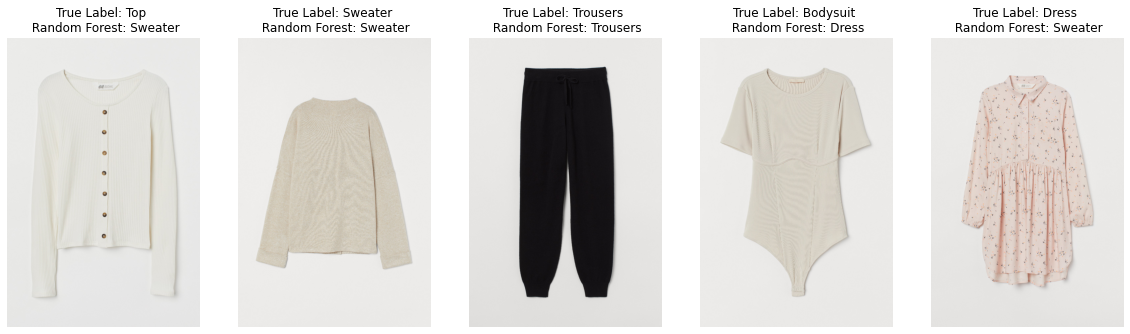

In [21]:
generate_caption()

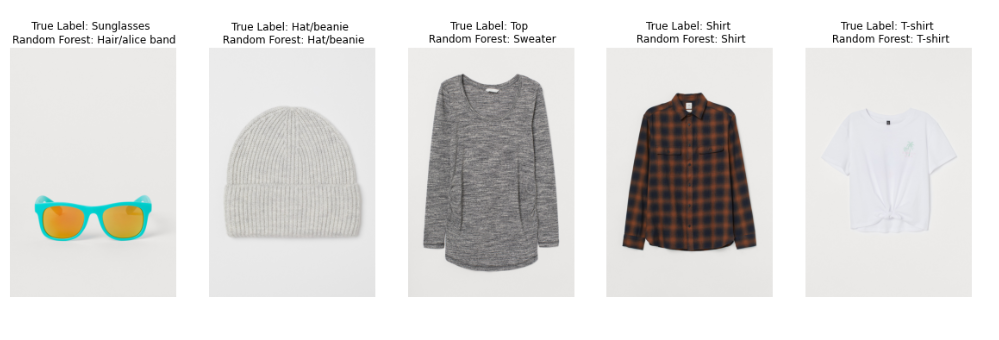

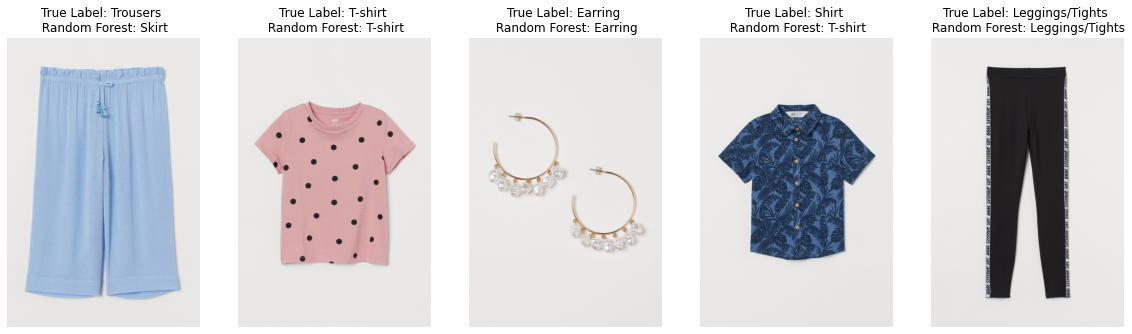

In [22]:
generate_caption()

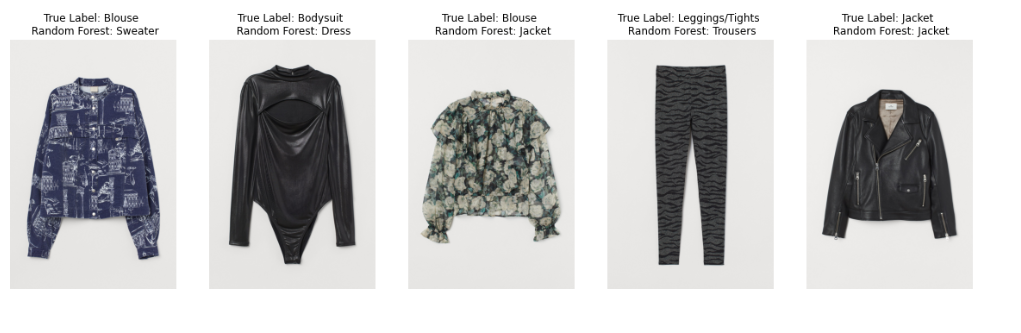

### Saving samples for demonstration

In [23]:
import matplotlib.pyplot as plt
from skimage.transform import resize
from PIL import Image
!mkdir images

def plot_items(items):
    path = "../input/h-and-m-personalized-fashion-recommendations/images"

    k = len(items)
    for item, i in zip(items, range(1, k+1)):
        sub = item[:3]
        image = path + "/"+ sub + "/"+ item +".jpg"
        image = Image.open(image)
       
        basewidth = 360
        wpercent = (basewidth / float(image.size[0]))
        hsize = int((float(image.size[1]) * float(wpercent)))
        image = image.resize((basewidth, hsize), Image.ANTIALIAS)
        image.save("./images/{}.jpeg".format(item[1:]))

In [24]:
plot_items(sample_y.index.values)

In [25]:
f = open('model.pickle', 'wb')
pickle.dump(model, f)

In [26]:
sample_y.to_csv('product_tagging.csv')